# Setup

In [81]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from ssm import *
import pandas as pd
import os
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import re
npr.seed(0)

In [51]:
root_dir = '/Users/colineleteurtre/Library/CloudStorage/OneDrive-Personnel/Documents/cours/EPFL/MA2/projet_sem/visual-perception'
root_dir = os.getcwd()

### what to do
save_data = True
bias = True

test_type = 'with006'

test_type_title = ''
if test_type.startswith("without") and test_type.endswith("ms"):
    n_ms = int(re.search(r"without(\d+)ms", test_type).group(1))

if test_type.startswith("without") and test_type.endswith("ms"):    
    if n_ms != 0:
        test_type_title = ' - without<' + str(n_ms) + 'ms'
    else: test_type_title = ' - without0ms'
elif test_type == 'withoutbias':
    test_type_title = ' - without bias'
    bias = False
elif test_type == 'without006':
    test_type_title = ' - without 006'
elif test_type == 'test_model':
    test_type_title = ' - test'
elif test_type == 'with006':
    test_type_title = ' - test'
elif test_type == 'with006':
    test_type_title = ''
elif test_type == 'ketamindata':
    test_type_title = ' - ketamindata'

want_another_test = False

## Initialize GLM-HMM

### Check that the model is working

In [52]:
if want_another_test == True:
    n = 9000 #number of trials
    trials = np.arange(1, n +1)
    responses = np.zeros(n, dtype=int)
    stimulus = np.random.choice([-1, 1], size=n)

    orientation_perc_external = 0.70
    prev_resp_perc_external = 1 - orientation_perc_external
    orientation_perc_internal = 0.10
    prev_resp_perc_internal = 1 - orientation_perc_internal

    breakpoints = np.sort(np.random.choice(range(1, n), size=19, replace=False))
    breakpoints = np.concatenate(([0], breakpoints, [n]))
    intervals = [trials[breakpoints[i]:breakpoints[i+1]] for i in range(len(breakpoints) - 1)]

    odd_length = 0
    even_length = 0

    for i, interval in enumerate(intervals):
        interval_length = len(interval)
        if (i+1)%2 == 0:                #i+1 even -> external state
            even_length += interval_length
            for j in range(len(interval)):
                idx = interval[j] - 1 
                if np.random.rand() < orientation_perc_external:
                    responses[idx] = stimulus[idx]
                else:
                    if idx > 0:
                        responses[idx] = responses[idx - 1]
                    else:
                        responses[idx] = stimulus[idx]  
        else:                           #i+1 odd -> internal state
            odd_length += interval_length
            for j in range(len(interval)):
                idx = interval[j] - 1  
                if np.random.rand() < orientation_perc_internal:
                    responses[idx] = stimulus[idx]
                else:
                    if idx > 0:
                        responses[idx] = responses[idx - 1]
                    else:
                        responses[idx] = stimulus[idx] 

    prev_resp = np.zeros_like(responses)
    prev_resp[1:] = responses[:-1] 
    responses[responses == -1] = 0

    total_length = odd_length + even_length
    fraction_odd = odd_length / total_length
    fraction_even = even_length / total_length
    print(f"Fraction of odd intervals (internal): {fraction_odd:.2f} versus even intervals (external): {fraction_even:.2f}")


    interval_data = pd.DataFrame({
    'Breakpoints': breakpoints[:-1],
    'Intervals': intervals})
    interval_data.to_csv(root_dir + f'/test_model_intervals_{fraction_odd * 100:.0f}.csv', index=False)


    final_df = pd.DataFrame({
    'ID': np.ones(n, dtype=int),         
    'block': np.ones(n, dtype=int),      
    'theta': stimulus,                   
    'prev_resp': prev_resp,              
    'resp': responses,                   
    'correct': np.zeros(n, dtype=int)    
    })

    final_df['correct'] = np.where((final_df['theta'] == -1) & (final_df['resp'] == 0), 1,
                    np.where((final_df['theta'] == -1) & (final_df['resp'] == 1), 0,
                    np.where((final_df['theta'] ==1)  & (final_df['resp'] == 1), 1, 0)))

    final_df.to_csv(root_dir + f'/Full_Data/Full_Data_test_model_{fraction_odd * 100:.0f}.csv', index=False)



    fig, ax = plt.subplots(figsize=(5, 2.5))
    cols = ['#ff7f00', '#4daf4a', '#377eb8',  '#8B0000', '#000000']

    for i, interval in enumerate(intervals):
        start = breakpoints[i]
        end = breakpoints[i + 1]

        if (i+1) % 2 == 0:
            color = cols[0]
        else:
            color = cols[1]
        
        ax.add_patch(plt.Rectangle((start, 0), end - start, 1, color=color))

    even_patch = mpatches.Patch(color= cols[1], label='Even Interval')
    odd_patch = mpatches.Patch(color= cols[0], label='Odd Interval')
    ax.legend(handles=[even_patch, odd_patch], loc='upper right')

    ax.set_xlim(0, 9000)  
    ax.set_ylim(0, 1)    
    plt.yticks([0, 0.5, 1], fontsize = 10)
    ax.set_xlabel('Trials')
    ax.set_ylabel('Value')
    ax.set_title('Intervals Distribution')
    plt.savefig(root_dir + f'/plots/test_model/intervals_distribution_orientation.png', bbox_inches="tight")

    plt.show()

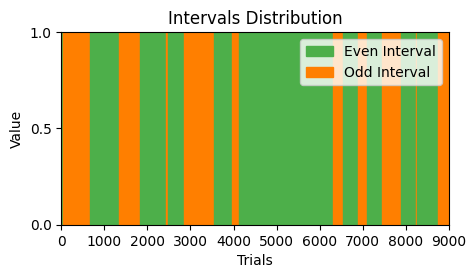

In [53]:
if want_another_test == False:
    interval_data = pd.read_csv(root_dir + '/test_model_intervals_64.csv') 
    def clean(x):
        return [int(i) for i in x.replace("\n", " ").strip("[]").split() if i.strip('-').isdigit()]

    intervals = interval_data["Intervals"].apply(clean)
    breakpoints = interval_data["Breakpoints"].tolist()
    breakpoints.append(intervals.iloc[-1][-1])
    
    # the following parameters depend on the interval_data file that was pre-created
    orientation_perc_external = 0.70       
    prev_resp_perc_external = 1 - orientation_perc_external
    orientation_perc_internal = 0.10
    prev_resp_perc_internal = 1 - orientation_perc_internal

    fraction_odd = 0.64
    fraction_even = 1 - fraction_odd

fig, ax = plt.subplots(figsize=(5, 2.5))
cols = ['#ff7f00', '#4daf4a', '#377eb8',  '#8B0000', '#000000']

for i, interval in enumerate(intervals):
    start = breakpoints[i]
    end = breakpoints[i + 1]

    if (i+1) % 2 == 0:
        color = cols[0]
    else:
        color = cols[1]
    
    ax.add_patch(plt.Rectangle((start, 0), end - start, 1, color=color))

even_patch = mpatches.Patch(color= cols[1], label='Even Interval')
odd_patch = mpatches.Patch(color= cols[0], label='Odd Interval')
ax.legend(handles=[even_patch, odd_patch], loc='upper right')

ax.set_xlim(0, 9000)  
ax.set_ylim(0, 1)    
plt.yticks([0, 0.5, 1], fontsize = 10)
ax.set_xlabel('Trials')
ax.set_ylabel('Value')
ax.set_title('Intervals Distribution')
plt.savefig(root_dir + f'/plots/test_model/intervals_distribution_orientation.png', bbox_inches="tight")

plt.show()

### Load and prepare inputs

In [54]:
if test_type == 'test_model' and want_another_test == False:
    final_df = pd.read_csv(root_dir + f'/Full_Data/Full_Data_test_model_64.csv')

In [55]:
if test_type != 'test_model':
    ### read and data 
    dfs = []
    columns_to_keep = ['theta', 'resp', 'block', 'correct', 'isi_ms']

    n = 6 #number of participants 

    if test_type.startswith("without") and test_type.endswith("ms"):
        if n_ms != 0:
            for i in range (n):
                df = pd.read_csv(f'{root_dir}/Data/00{i+1}/00{i+1}.csv')[columns_to_keep]
                df['ID'] = i+1  
                df.loc[df['isi_ms'] < n_ms, 'resp'] = 0        
                df['prev_resp'] = df.groupby('block')['resp'].shift(1, fill_value=0)
                df = df[df['isi_ms'] >= n_ms]
                dfs.append(df)
        else :
            for i in range (n):
                df = pd.read_csv(f'{root_dir}/Data/00{i+1}/00{i+1}.csv')[columns_to_keep]
                df['ID'] = i+1  
                df.loc[df['isi_ms'] <= n_ms, 'resp'] = 0        
                df['prev_resp'] = df.groupby('block')['resp'].shift(1, fill_value=0)
                df = df[df['isi_ms'] > n_ms]
                dfs.append(df)

    else:
        for i in range (n):
            df = pd.read_csv(f'{root_dir}/Data/00{i+1}/00{i+1}.csv')[columns_to_keep]
            df['ID'] = i+1  
            df['prev_resp'] = df.groupby('block')['resp'].shift(1, fill_value=0)
            dfs.append(df)

    final_df = pd.concat(dfs, ignore_index=True)
    final_df = final_df[['ID', 'block', 'theta', 'prev_resp', 'resp', 'correct', 'isi_ms']]
    final_df['resp'] = final_df['resp'].replace(-1, 0)
    final_df['theta'] = final_df['theta'].replace(-45, -1)
    final_df['theta'] = final_df['theta'].replace(45, 1)
    final_df.to_csv(root_dir + '/Full_Data/Full_Data.csv', index=False)

In [56]:
#isi,block,trial,isi_ms,isi_frames,theta,log_cnt,resp,rt,stim_duration,blank_duration,cnt,correct
#33,1,1,640,64,-45,-1.8546873026985,-1,0.546695,0.0482276000002457,0.645238199999767,0.0139737412527265,1

In [57]:
summary = {}
for col in final_df.columns:
    unique_values = final_df[col].unique()
    summary[col] = unique_values.tolist()
for col, types in summary.items():
    print(f"{col}: {types}")

ID: [1, 2, 3, 4, 5, 6]
block: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
theta: [-1, 1]
prev_resp: [0, -1, 1]
resp: [0, 1]
correct: [1, 0]
isi_ms: [640, 100, 920, 620, 440, 580, 680, 820, 460, 1000, 360, 800, 280, 880, 760, 40, 240, 300, 60, 600, 980, 540, 560, 780, 20, 220, 340, 660, 160, 960, 420, 0, 740, 400, 180, 80, 700, 140, 320, 860, 260, 720, 120, 380, 900, 840, 940, 200, 500, 520, 480]


### Plot Mean Correctness versus ID

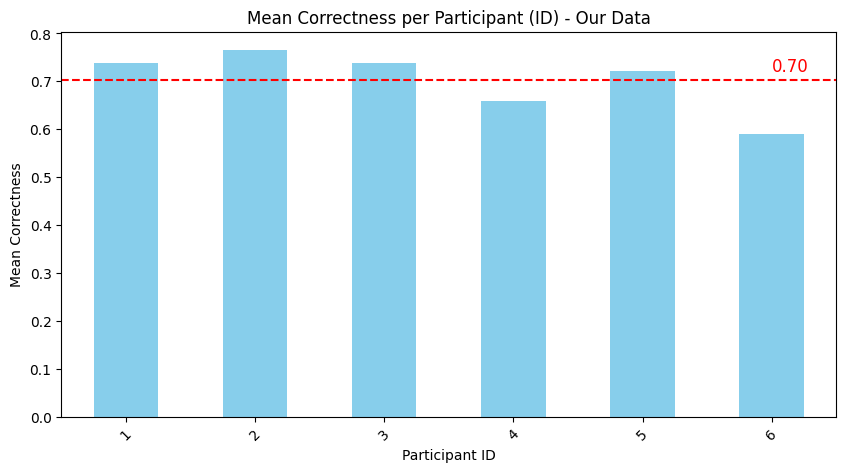

In [58]:
# Group by ID and calculate the mean correctness
mean_correctness = final_df.groupby("ID")["correct"].mean()

# Calculate the mean of the means
mean_of_means = mean_correctness.mean()

# Plot the means of correctness for each participant
plt.figure(figsize=(10, 5))
mean_correctness.plot(kind="bar", color="skyblue")
plt.axhline(mean_of_means, color="red", linestyle="--", label=f"Mean of Means: {mean_of_means:.2f}")
plt.text(len(mean_correctness) - 1, mean_of_means + 0.02, f"{mean_of_means:.2f}", color="red", fontsize=12)

if (test_type.startswith("without") and test_type.endswith("ms")) or (test_type == "test_model"):
    plt.title(f"Mean Correctness per Participant (ID){test_type_title}")
else : plt.title(f"Mean Correctness per Participant (ID) - Our Data")
plt.xlabel("Participant ID")
plt.ylabel("Mean Correctness")
plt.xticks(rotation=45)
plt.savefig(root_dir + f'/plots/{test_type}/mean_correctness_per_participant.png', bbox_inches="tight")
plt.show()

### Plot Mean Correctness versus isi_ms

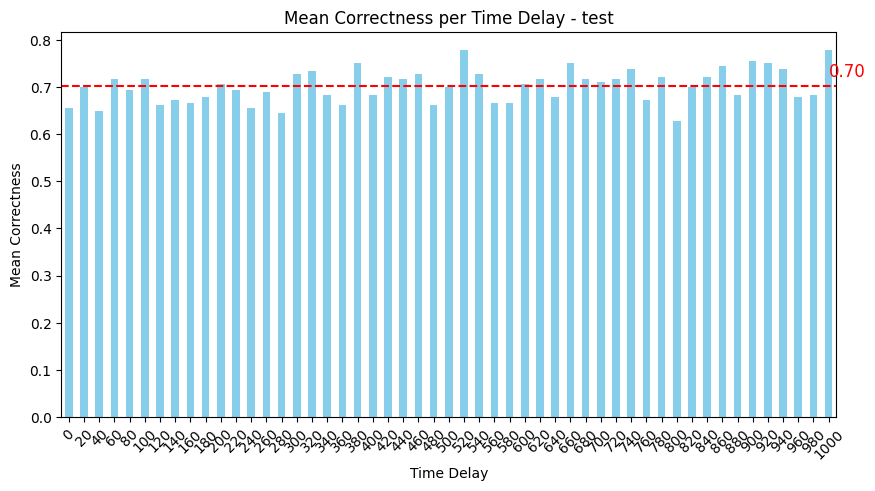

In [59]:
if test_type != 'test_model':
    # Group by ID and calculate the mean correctness
    mean_correctness = final_df.groupby("isi_ms")["correct"].mean()

    # Calculate the mean of the means
    mean_of_means = mean_correctness.mean()

    # Plot the means of correctness for each participant
    plt.figure(figsize=(10, 5))
    mean_correctness.plot(kind="bar", color="skyblue")
    plt.axhline(mean_of_means, color="red", linestyle="--", label=f"Mean of Means: {mean_of_means:.2f}")
    plt.text(len(mean_correctness) - 1, mean_of_means + 0.02, f"{mean_of_means:.2f}", color="red", fontsize=12)

    plt.title(f"Mean Correctness per Time Delay{test_type_title}")
    plt.xlabel("Time Delay")
    plt.ylabel("Mean Correctness")
    plt.xticks(rotation=45)
    plt.savefig(root_dir + f'/plots/{test_type}/mean_correctness_per_time_delay.png', bbox_inches="tight")
    plt.show()

### Verify Congruence

In [ ]:
# Compute prev_resp_congruent:
# - when prev_resp = -1 and resp = 0 → congruent
# - when prev_resp = 1 and resp = 1 → congruent
final_df["prev_resp_congruent"] = np.where(
    ((final_df["prev_resp"] == -1) & (final_df["resp"] == 0)) |
    ((final_df["prev_resp"] == 1) & (final_df["resp"] == 1)),
    1,
    0
)

# Compute orientation_congruent:
# - when theta = -1 and resp = 0 → congruent
# - when theta = 1 and resp = 1 → congruent
final_df["orientation_congruent"] = np.where(
    ((final_df["theta"] == -1) & (final_df["resp"] == 0)) |
    ((final_df["theta"] == 1) & (final_df["resp"] == 1)),
    1,
    0
)

[1 2 3 4 5 6]


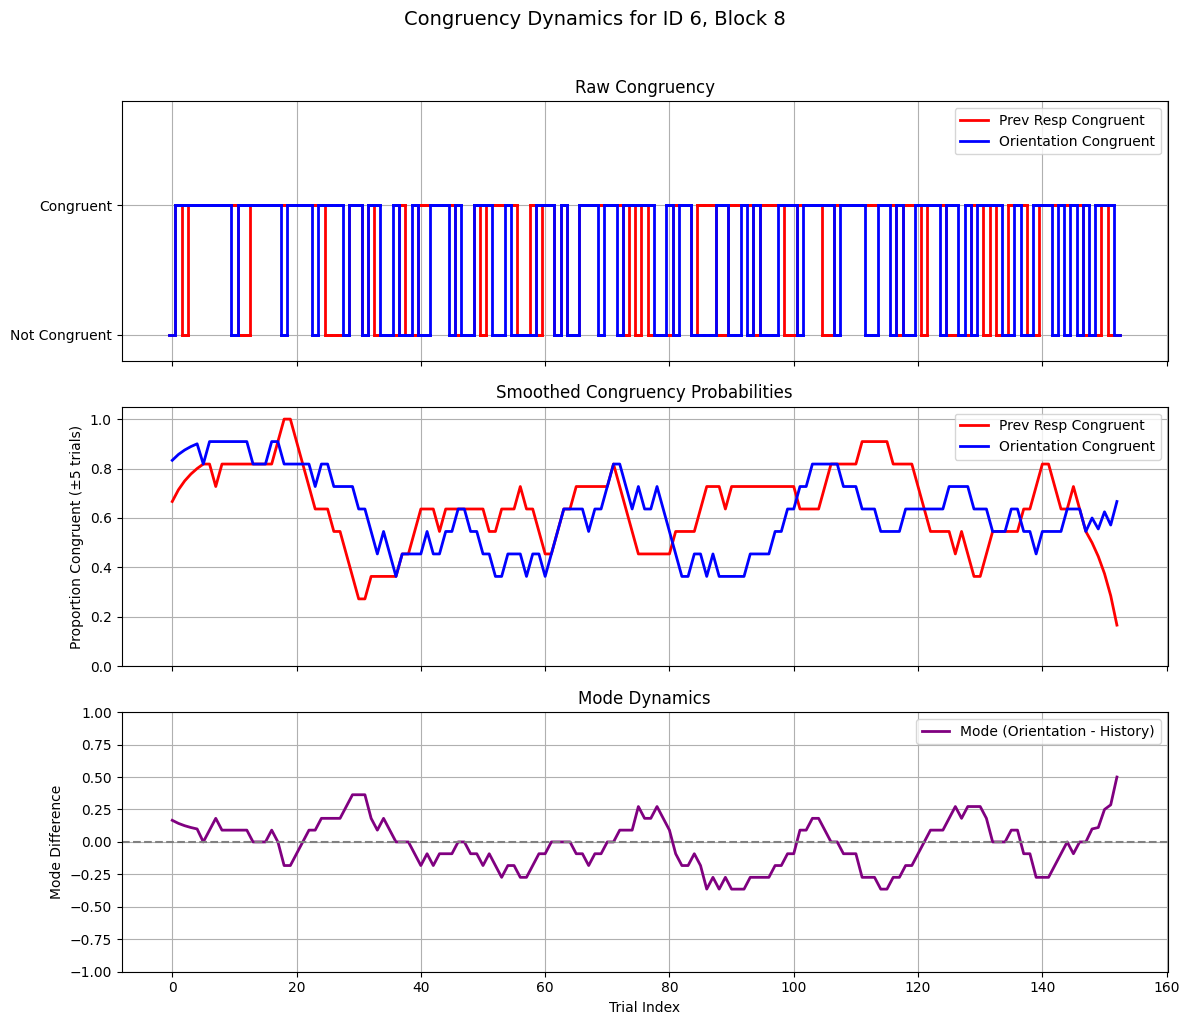

In [100]:
selected_id = 6     # from 1 to 6
selected_block = 8  # from 1 to 10
window_size = 5     # ±5 trials

df_congruence = final_df[(final_df["ID"] == selected_id) & (final_df["block"] == selected_block)].copy()
df_congruence.reset_index(drop=True, inplace=True)

x = np.arange(len(df_congruence))
y1 = df_congruence["prev_resp_congruent"].values
y2 = df_congruence["orientation_congruent"].values

def draw_step_signal(ax, x, y, color):
    for i in range(len(x) - 1):
        ax.plot([x[i]-0.5, x[i]+0.5], [y[i], y[i]], color=color, linewidth=2)
        if y[i] == y[i+1]:
            ax.plot([x[i]+0.5, x[i+1]+0.5], [y[i], y[i+1]], color=color, linewidth=2)
        else:
            ax.vlines(x[i]+0.5, 0, 1, colors=color, linewidth=2)
            ax.plot([x[i]+0.5, x[i+1]+0.5], [y[i+1], y[i+1]], color=color, linewidth=2)

def smooth_congruency(arr, window):
    return np.array([
        np.mean(arr[max(0, i - window):min(len(arr), i + window + 1)])
        for i in range(len(arr))
    ])

y1_smooth = smooth_congruency(y1, window_size)
y2_smooth = smooth_congruency(y2, window_size)
mode = y2_smooth - y1_smooth

# === Plot all 3 in stacked subplots ===
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# 1. Step plot of raw congruencies
draw_step_signal(axs[0], x, y1, color="red")
draw_step_signal(axs[0], x, y2, color="blue")
axs[0].set_ylim(-0.2, 1.8)
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels(["Not Congruent", "Congruent"])
axs[0].set_title("Raw Congruency")
legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='Prev Resp Congruent'),
    Line2D([0], [0], color='blue', lw=2, label='Orientation Congruent')
]
axs[0].legend(handles=legend_elements)
axs[0].grid(True)

# 2. Smoothed probabilities
axs[1].plot(x, y1_smooth, label="Prev Resp Congruent", color="red", linewidth=2)
axs[1].plot(x, y2_smooth, label="Orientation Congruent", color="blue", linewidth=2)
axs[1].set_ylim(0, 1.05)
axs[1].set_ylabel("Proportion Congruent (±5 trials)")
axs[1].set_title("Smoothed Congruency Probabilities")
axs[1].legend()
axs[1].grid(True)

# 3. Mode
axs[2].plot(x, mode, color="purple", linewidth=2, label="Mode (Orientation - History)")
axs[2].axhline(0, color="gray", linestyle="--", linewidth=1.5)
axs[2].set_ylim(-1, 1)
axs[2].set_xlabel("Trial Index")
axs[2].set_ylabel("Mode Difference")
axs[2].set_title("Mode Dynamics")
axs[2].legend()
axs[2].grid(True)

plt.suptitle(f"Congruency Dynamics for ID {selected_id}, Block {selected_block}", fontsize=14, y=1.02)
plt.tight_layout()

plt.savefig(root_dir + f'/plots/{test_type}/congruency.png', bbox_inches="tight")

plt.show()


### Initialize GLM-HMM

In [12]:
### Set the parameters of the GLM-HMM
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
if bias == True:
    input_dim = 3
else: 
    input_dim = 2 
N_iters = 500

In [13]:
inpts = []
choices = []
participants = final_df["ID"].unique()

for load_idx in participants:
    this_data = final_df.loc[final_df['ID'] == load_idx].copy()
        ## start with estimating the experiment as a whole
    num_sess = 1
    num_trials_per_sess = len(this_data)

    new_inpts = []
    new_choices = []

    new_inpts = np.ones((num_trials_per_sess, input_dim))
    
    ## get input format
    new_inpts[:, 0] = this_data['theta'].copy()
    new_inpts[:, 1] = this_data['prev_resp'].copy()
    if bias == True:
        new_inpts[:, 2] = np.ones(this_data.shape[0])
    inpts.append(new_inpts)

    new_choices = this_data['resp'].copy()
    new_choices = np.atleast_2d(new_choices).T
    choices.append(new_choices) 

## Fit at group-level in one-state GLM-HMM

In [14]:
### fit one state GLM-HMM at group level

num_states = 1
n_iter = 100

transition_alpha = 1
prior_sigma = 10

if bias == True:
    iter_array = np.full([n_iter, 3], np.nan)
else:
    iter_array = np.full([n_iter, 2], np.nan)
for idx in range(n_iter):
    
    one_state_glmhmm = HMM(num_states, obs_dim, input_dim, 
                    observations="input_driven_obs", 
                    observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                    transitions="sticky", 
                    transition_kwargs=dict(alpha=transition_alpha, kappa=0))
    print(one_state_glmhmm.params)
    one_state_glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, initialize = True, tolerance=10**-4, verbose = False)
    if bias == True:
        iter_array[idx,] = one_state_glmhmm.observations.params.reshape((1,3))
    else:
        iter_array[idx,] = one_state_glmhmm.observations.params.reshape((1,2))


((array([-0.]),), (array([[0.]]),), array([[[0.74159174, 1.55291372]]]))


((array([-0.]),), (array([[0.]]),), array([[[ 1.86755799, -0.97727788]]]))
((array([-0.]),), (array([[0.]]),), array([[[ 1.26611853, -0.50587654]]]))
((array([-0.]),), (array([[0.]]),), array([[[0.76103773, 0.12167502]]]))
((array([-0.]),), (array([[0.]]),), array([[[0.48431215, 0.57914048]]]))
((array([-0.]),), (array([[0.]]),), array([[[ 1.49407907, -0.20515826]]]))
((array([-0.]),), (array([[0.]]),), array([[[-0.96075461,  0.37692697]]]))
((array([-0.]),), (array([[0.]]),), array([[[-2.55298982,  0.6536186 ]]]))
((array([-0.]),), (array([[0.]]),), array([[[-0.24214951,  1.51439128]]]))
((array([-0.]),), (array([[0.]]),), array([[[ 0.04575852, -0.18718385]]]))
((array([-0.]),), (array([[0.]]),), array([[[0.56644004, 0.14926509]]]))
((array([-0.]),), (array([[0.]]),), array([[[-0.88778575, -1.98079647]]]))
((array([-0.]),), (array([[0.]]),), array([[[ 0.17538653, -0.46250554]]]))
((array([-0.]),), (array([[0.]]),), array([[[-0.38732682, -0.30230275]]]))
((array([-0.]),), (array([[0.]]

In [15]:
if bias == True:
    df_iter_array = pd.DataFrame(iter_array, columns = ['theta', 'prev_resp', 'bias'])
else:
    df_iter_array = pd.DataFrame(iter_array, columns = ['theta', 'prev_resp'])
if save_data:
    df_iter_array.to_csv(root_dir + f'/HMM/{test_type}/one_level_HMM_params.csv', index = False) 

In [16]:
df_iter_array = pd.read_csv(root_dir + f'/HMM/{test_type}/one_level_HMM_params.csv')
params_for_initalization = df_iter_array.mean().values
print(params_for_initalization)

[-4.22657599 -5.05191206]


# Fit multi-state GLM-HMMs at group-level and compare BIC

In [17]:
## compare models based on BIC
max_num_states =  2    # number of discrete states

N_iters = 500 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
# Make a GLM-HMM
prior_sigma = 10
transition_alpha = 1

BIC = []
for state_idx in range(max_num_states): 
    print(state_idx)
    compare_glmhmm = HMM(state_idx+1, obs_dim, input_dim, 
                    observations="input_driven_obs", 
                    observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                    transitions="sticky", 
                    transition_kwargs=dict(alpha=transition_alpha, kappa=0))

    
    _ = compare_glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, initialize = True, tolerance=10**-4, verbose = False)
    n_total_params = np.concatenate(compare_glmhmm.observations.params).size + np.concatenate(compare_glmhmm.transitions.params).size
    
    # Flatten choices and inpts to calculate log likelihood correctly
    flattened_choices = np.concatenate(choices)
    flattened_inpts = np.concatenate(inpts)

    new_BIC = np.log(np.size(flattened_choices))*n_total_params - 2*compare_glmhmm.log_likelihood(choices, inputs=inpts)
    
    if save_data:
        pd.DataFrame(np.append(new_BIC, np.concatenate(compare_glmhmm.observations.params))).to_csv(root_dir + f'/HMM/{test_type}/Full_model_outcome_states_' + str(state_idx + 1) + '.csv', index = False)

    BIC = np.append(BIC, new_BIC) 
    print(compare_glmhmm.observations.params)

df_BIC = pd.DataFrame({'BIC': BIC, 'num_states': np.arange(max_num_states) + 1})


if save_data:
    df_BIC.to_csv(root_dir + f'/HMM/{test_type}/BIC_across_models.csv', index = False)


0


[[[-4.19880401 -5.02413994]]]
1
[[[-4.19536684 -6.50890744]]

 [[-5.55771295 -4.72465677]]]


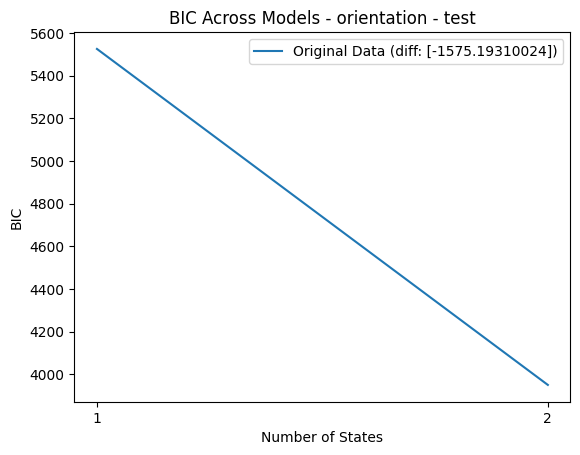

In [18]:
df_BIC = pd.read_csv(root_dir + f'/HMM/{test_type}/BIC_across_models.csv')
bic_diff = np.diff(df_BIC.BIC)

plt.plot(df_BIC['num_states'], df_BIC['BIC'], label=f'Original Data (diff: {bic_diff})')
plt.title(f'BIC Across Models - orientation{test_type_title}')
plt.xlabel('Number of States')
plt.ylabel('BIC')
plt.legend()
plt.xticks([1, 2])
plt.savefig(root_dir + f'/plots/{test_type}/BIC_across_models_orientation.png', bbox_inches='tight')
plt.show()

# Fit permuted multi-state GLM-HMMs at group-level and compare BIC

In [19]:
# Permutation analysis
n_perm = 100
BIC_permuted = []

for perm_idx in range(n_perm):
    permuted_choices = []
    permuted_inpts = []
    
    for i in range(len(choices)):
        perm_indices = np.random.permutation(choices[i].shape[0])
        permuted_choices.append(choices[i][perm_indices])
        permuted_inpts.append(inpts[i][perm_indices])
    
    for state_idx in range(max_num_states):
        print(f"Permutation {perm_idx}, State {state_idx}")
        permuted_glmhmm = HMM(state_idx + 1, obs_dim, input_dim, 
                                  observations="input_driven_obs", 
                                  observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                                  transitions="sticky", 
                                  transition_kwargs=dict(alpha=transition_alpha, kappa=0))

        _ = permuted_glmhmm.fit(permuted_choices, inputs=permuted_inpts, method="em", num_iters=N_iters, initialize=True, tolerance=10**-4, verbose=False)

        n_total_params = np.concatenate(permuted_glmhmm.observations.params).size + np.concatenate(permuted_glmhmm.transitions.params).size

        # Compute log likelihood
        log_likelihood = permuted_glmhmm.log_likelihood(permuted_choices, inputs=permuted_inpts)

        # Compute BIC
        new_BIC = np.log(len(flattened_choices)) * n_total_params - 2 * log_likelihood
        BIC_permuted.append({'perm_idx': perm_idx, 'state_idx': state_idx + 1, 'BIC': new_BIC})

df_BIC_permuted = pd.DataFrame(BIC_permuted)
if save_data:
    df_BIC_permuted.to_csv(root_dir + f'/HMM/{test_type}/BIC_permuted_across_models.csv', index=False)

Permutation 0, State 0
Permutation 0, State 1
Permutation 1, State 0
Permutation 1, State 1
Permutation 2, State 0
Permutation 2, State 1
Permutation 3, State 0
Permutation 3, State 1
Permutation 4, State 0
Permutation 4, State 1
Permutation 5, State 0
Permutation 5, State 1
Permutation 6, State 0
Permutation 6, State 1
Permutation 7, State 0
Permutation 7, State 1
Permutation 8, State 0
Permutation 8, State 1
Permutation 9, State 0
Permutation 9, State 1
Permutation 10, State 0
Permutation 10, State 1
Permutation 11, State 0
Permutation 11, State 1
Permutation 12, State 0
Permutation 12, State 1
Permutation 13, State 0
Permutation 13, State 1
Permutation 14, State 0
Permutation 14, State 1
Permutation 15, State 0
Permutation 15, State 1
Permutation 16, State 0
Permutation 16, State 1
Permutation 17, State 0
Permutation 17, State 1
Permutation 18, State 0
Permutation 18, State 1
Permutation 19, State 0
Permutation 19, State 1
Permutation 20, State 0
Permutation 20, State 1
Permutation 

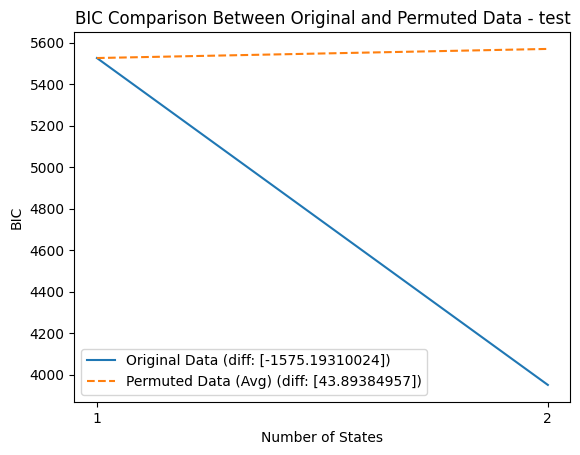

In [20]:
# Average BIC across permutations
df_BIC_permuted_avg = df_BIC_permuted.groupby('state_idx').agg({'BIC': 'mean'}).reset_index()
bic_diff = np.diff(df_BIC['BIC'])
bic_diff_permuted = np.diff(df_BIC_permuted_avg['BIC'])

# Plotting
plt.plot(df_BIC['num_states'], df_BIC['BIC'], label=f'Original Data (diff: {bic_diff})')
plt.plot(df_BIC_permuted_avg['state_idx'], df_BIC_permuted_avg['BIC'], label=f'Permuted Data (Avg) (diff: {bic_diff_permuted})', linestyle='--')
plt.xlabel('Number of States')
plt.ylabel('BIC')
plt.legend()
plt.title(f'BIC Comparison Between Original and Permuted Data{test_type_title}')
plt.xticks([1, 2])
plt.savefig(root_dir + f'/plots/{test_type}/BIC_comparison_orientation.png', bbox_inches='tight')
plt.show()

# Fit two-state GLM-HMMs 

In [21]:
npr.seed(0)
# Set the parameters of the GLM-HMM
num_states =  2      # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
if bias == True:
    input_dim = 3
else:
    input_dim = 2       # input dimensions

N_iters = 500 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
# Make a GLM-HMM

prior_sigma = 10
transition_alpha = 1

n_iter = 10
if bias == True:
    parameters_ext_int = np.full([n_iter, 10], np.nan) 
else:
    parameters_ext_int = np.full([n_iter, 8], np.nan)
for idx in range(n_iter):
    print(idx)
    glmhmm = HMM(num_states, obs_dim, input_dim, 
                        observations="input_driven_obs", 
                        observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                        transitions="sticky", 
                        transition_kwargs=dict(alpha=transition_alpha, kappa=0))
    
    #if bias == True:
    #    glmhmm.observations.params =  np.tile(params_for_initalization, (num_states,1)).reshape(num_states, 1, 3)
    #else:
    #    glmhmm.observations.params =  np.tile(params_for_initalization, (num_states,1)).reshape(num_states, 1, 2) 
    _ = glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, initialize = True, tolerance=10**-4, verbose = False)
   
    index_ext = np.argmax(np.concatenate(-glmhmm.observations.params)[:,0])
    index_int = np.argmin(np.concatenate(-glmhmm.observations.params)[:,0])
    parameters_ext_int[idx,] = np.concatenate((-glmhmm.observations.params[index_ext,:], -glmhmm.observations.params[index_int,:], glmhmm.transitions.params[0].reshape(1,4)), axis = 1)
    del(glmhmm)


0
1
2
3
4
5
6
7
8
9


en gros, ext c'est pour la phase externale, int pour la phase internale où les coefs sont moins importants

In [22]:
if bias == True:
    df_two_state_init = pd.DataFrame(parameters_ext_int, columns = ['orientation_ext', 'prev_resp_ext', 'bias_ext',
                                                                'orientation_int', 'prev_resp_int', 'bias_int',
                                                                 'AA', 'AB', 'BA', 'BB']) 
else:
    df_two_state_init = pd.DataFrame(parameters_ext_int, columns = ['orientation_ext', 'prev_resp_ext',
                                                                'orientation_int', 'prev_resp_int',
                                                                 'AA', 'AB', 'BA', 'BB']) 


In [23]:
if save_data:
    df_two_state_init.to_csv(root_dir + f'/HMM/{test_type}/two_state_init_param.csv', index = False)

In [24]:
df_two_state_init = pd.read_csv(root_dir + f'/HMM/{test_type}/two_state_init_param.csv')

In [25]:
df_two_state_init.mean()

orientation_ext    5.514228
prev_resp_ext      4.681172
orientation_int    4.172926
prev_resp_int      6.485364
AA                -0.002257
AB                -6.130390
BA                -5.905065
BB                -0.002815
dtype: float64

In [26]:
external_ratio = np.exp(df_two_state_init.mean()['orientation_ext'])/np.exp(df_two_state_init.mean()['prev_resp_ext'])
internal_ratio = np.exp(df_two_state_init.mean()['orientation_int'])/np.exp(df_two_state_init.mean()['prev_resp_int'])
print("External state ratio (o/pr):", external_ratio)
print("Internal state ratio (o/pr):", internal_ratio)

o_external_ratio = 100*external_ratio/(external_ratio+1)
o_internal_ratio = 100*internal_ratio/(internal_ratio+1)
print("External state ratio in % (o/pr):", o_external_ratio, "/", 100-o_external_ratio)
print("Internal state ratio in % (o/pr):", o_internal_ratio, "/", 100-o_internal_ratio)

External state ratio (o/pr): 2.3003371076340455
Internal state ratio (o/pr): 0.09901952335624543
External state ratio in % (o/pr): 69.70006495133818 / 30.299935048661823
Internal state ratio in % (o/pr): 9.0098056724101 / 90.9901943275899


In [27]:
df_two_state_init = pd.read_csv(root_dir + f'/HMM/{test_type}/two_state_init_param.csv')
param_init_ext_int = df_two_state_init.mean().values

if bias == True:
    recovered_weights = -param_init_ext_int[0:6].reshape(2,1,3)         
    recovered_trans_mat = np.exp(param_init_ext_int[6:10].reshape(2,2)) 
else:
    recovered_weights = -param_init_ext_int[0:4].reshape(2,1,2)    
    recovered_trans_mat = np.exp(param_init_ext_int[4:8].reshape(2,2))     

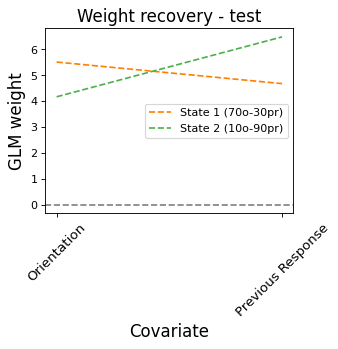

In [28]:
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8',  '#8B0000', '#000000']
if test_type == "test_model":
    for k in range(num_states):
        if k==0:
            plt.plot(range(input_dim), -recovered_weights[k][0], color=cols[k],
                        lw=1.5,  label = f"State 1 ({orientation_perc_external* 100:.0f}o-{prev_resp_perc_external* 100:.0f}pr)", linestyle = '--') #State 1 (70o-30pr)
        else:
            plt.plot(range(input_dim), -recovered_weights[k][0], color=cols[k],
                        lw=1.5,  label = f'State 2 ({orientation_perc_internal* 100:.0f}o-{prev_resp_perc_internal* 100:.0f}pr)', linestyle = '--') #State 2 (10o-90pr)
else:
    for k in range(num_states):
        if k==0:
            plt.plot(range(input_dim), -recovered_weights[k][0], color=cols[k],
                        lw=1.5,  label = "State 1 (external)", linestyle = '--')
        else:
            plt.plot(range(input_dim), -recovered_weights[k][0], color=cols[k],
                        lw=1.5,  label = 'State 2 (internal)', linestyle = '--') 
        
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("Covariate", fontsize=15)
if bias == True:
    plt.xticks([0, 1, 2], ['Orientation', 'Previous Response', 'Bias'], fontsize=12, rotation=45)
else:
    plt.xticks([0, 1], ['Orientation', 'Previous Response'], fontsize=12, rotation=45) 
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title(f"Weight recovery{test_type_title}", fontsize=15)
plt.savefig(root_dir + f'/plots/{test_type}/weight_recovery_orientation.png', bbox_inches='tight')
plt.show()

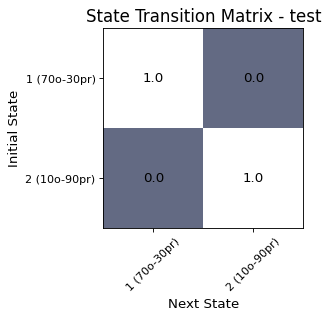

In [29]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)

if test_type == "test_model":
    plt.xticks(range(0, num_states), (f'1 ({orientation_perc_external* 100:.0f}o-{prev_resp_perc_external* 100:.0f}pr)',
                                      f'2 ({orientation_perc_internal* 100:.0f}o-{prev_resp_perc_internal* 100:.0f}pr)'),   #'1 (70o-30pr)', '2 (10o-90pr)'
                                      fontsize=10, rotation=45)
    plt.yticks(range(0, num_states), (f'1 ({orientation_perc_external* 100:.0f}o-{prev_resp_perc_external* 100:.0f}pr)',
                                      f'2 ({orientation_perc_internal* 100:.0f}o-{prev_resp_perc_internal* 100:.0f}pr)'),
                                      fontsize=10) 
else:
    plt.xticks(range(0, num_states), ('1 (external)', '2 (internal)'), fontsize=10, rotation=45)
    plt.yticks(range(0, num_states), ('1 (external)', '2 (internal)'), fontsize=10) 

plt.ylim(num_states - 0.5, -0.5)
plt.xlabel('Next State', fontsize=12)
plt.ylabel('Initial State', fontsize=12)
plt.title(f"State Transition Matrix{test_type_title}", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)
plt.savefig(root_dir + f'/plots/{test_type}/transitions_orientation.png', bbox_inches='tight')
plt.show()

## Posterior State Probabilities

Let's now plot $p(z_{t} = k|\mathbf{y}, \{u_{t}\}_{t=1}^{T})$, the posterior state probabilities, which give the probability of the animal being in state k at trial t.

In [30]:
# run average model
prior_sigma = 10

glmhmm = HMM(num_states, obs_dim, input_dim, 
                        observations="input_driven_obs", 
                        observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                        transitions="sticky", 
                        transition_kwargs=dict(alpha=transition_alpha, kappa=0))

if bias == True:
    glmhmm.init_state_distn.params = np.log([0.5, 0.5, 0.5]) 
    glmhmm.observations.params = -param_init_ext_int[0:6].reshape(2,1,3)
    glmhmm.transitions.params = (param_init_ext_int[6:10].reshape(2,2),)
else:    
    glmhmm.init_state_distn.params = np.log([0.5, 0.5])
    glmhmm.observations.params = -param_init_ext_int[0:4].reshape(2,1,2)
    glmhmm.transitions.params = (param_init_ext_int[4:8].reshape(2,2),)

_ = glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, initialize = False, tolerance=10**-4, verbose = False)
print(-glmhmm.observations.params)
index_ext = np.argmax(np.concatenate(-glmhmm.observations.params)[:,0])
index_int = np.argmin(np.concatenate(-glmhmm.observations.params)[:,0])

[[[5.58083282 4.74979219]]

 [[4.17292561 6.48536385]]]


In [31]:
# Get expected states:
posterior_probs = [glmhmm.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip(choices, inpts)]

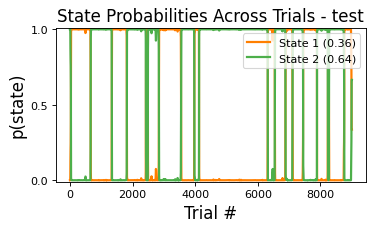

In [ ]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
if test_type == 'test_model':
    sess_id = 0 
else:
    sess_id = 5 #session id; can choose any index between 0 and num_sess-1=6-1=5
if test_type != 'test_model':
    for k in range(num_states):
        if k==0:
            plt.plot(posterior_probs[sess_id][1:1500, k], label="State 1 (external)", lw=2,
                color=cols[k])
        else:
            plt.plot(posterior_probs[sess_id][1:1500, k], label="State 2 (internal)", lw=2, 
                color=cols[k])
else:
    for k in range(num_states):
        if k==0:
            plt.plot(posterior_probs[sess_id][1:9000, k], label=f"State 1 ({fraction_even:.2f})", lw=2, #State 1 (36%)
                color=cols[k])
        else:
            plt.plot(posterior_probs[sess_id][1:9000, k], label=f"State 2 ({fraction_odd:.2f})", lw=2, #State 2 (64%)
                color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("Trial #", fontsize = 15)
plt.ylabel("p(state)", fontsize = 15)
plt.legend(loc="upper right", fontsize=10, title_fontsize=12)

if test_type == 'test_model':
    plt.title(f"State Probabilities Across Trials - test", fontsize=15)
else:
    plt.title(f"State Probabilities Across Trials for Participant {sess_id+1}{test_type_title}", fontsize=15)

if bias == True:
    plt.savefig(root_dir + f'/plots/{test_type}/probabilities_orientation.png', bbox_inches='tight')
else:
    plt.savefig(root_dir + f'/plots/{test_type}/probabilities_orientation_00{sess_id+1}.png', bbox_inches='tight')
plt.show()

With these posterior state probabilities, we can assign trials to states and then plot the fractional occupancy of each state:

In [35]:
# concatenate posterior probabilities across sessions
posterior_probs_concat = np.concatenate(posterior_probs)
# get state with maximum posterior probability at particular trial:
state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
# now obtain state fractional occupancies:
_, state_occupancies = np.unique(state_max_posterior, return_counts=True)
state_occupancies = state_occupancies/np.sum(state_occupancies)

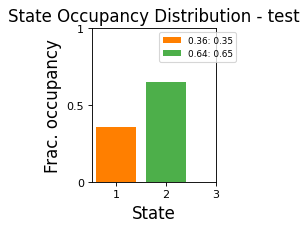

In [36]:
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
if test_type == 'test_model':
    for z, occ in enumerate(state_occupancies):
        if z==0:
            plt.bar(z, occ, width = 0.8, color = cols[z], label=f'{fraction_even:.2f}: {occ:.2f}')  #36%
        else:
            plt.bar(z, occ, width = 0.8, color = cols[z], label=f'{fraction_odd:.2f}: {occ:.2f}')   #64%
else:
    for z, occ in enumerate(state_occupancies):
        if z==0:
            plt.bar(z, occ, width = 0.8, color = cols[z], label=f'State 1 (external): {occ:.2f}')
        else:
            plt.bar(z, occ, width = 0.8, color = cols[z], label=f'State 2 (internal): {occ:.2f}') 

plt.ylim((0, 1))
plt.xticks([0, 1, 2], ['1', '2', '3'], fontsize = 10)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
plt.xlabel('State', fontsize = 15)
plt.ylabel('Frac. occupancy', fontsize=15)
plt.legend(loc="upper right", fontsize=8, title_fontsize=10, bbox_to_anchor=(1.2, 1))
plt.title(f"State Occupancy Distribution{test_type_title}", fontsize=15)
plt.savefig(root_dir + f'/plots/{test_type}/fraction_occupancy_orientation.png', bbox_inches='tight')
plt.show()

In [37]:
final_df = final_df.assign(Gl_Prob_State_ext = posterior_probs_concat[:,index_ext])
final_df = final_df.assign(Gl_Prob_State_int = posterior_probs_concat[:,index_int])

if save_data:
    if test_type == 'test_model':
        final_df.to_csv(root_dir + f'/Full_Data/Full_Data_test_model_{fraction_odd * 100:.0f}.csv', index = False)
    else:
        final_df.to_csv(root_dir + f'/Full_Data/Full_Data_{test_type}.csv', index = False)